In [1]:
import gnssmapper as gm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import interpolate

In [2]:
samples=pd.read_csv('../data/ucl_exact_samples.csv',index_col=0)
height= 46
samples_long=samples.melt(id_vars=('est_lb','est','est_ub'),var_name="metric",value_name='size')

In [195]:
samples=pd.read_csv('../data/hermitage_exact_samples.csv',index_col=0)
height= 34
samples_long=samples.melt(id_vars=('est_lb','est','est_ub'),var_name="metric",value_name='size')

Intersection Metrics and Window metrics have an inverse relationship

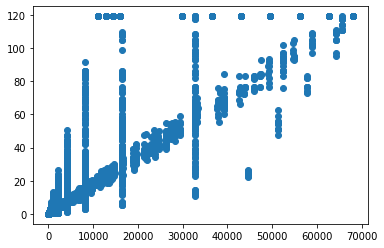

In [196]:
plt.scatter(samples.I_4,1/samples.W_100)

<AxesSubplot:>

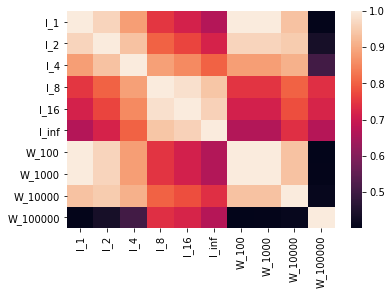

In [197]:
sns.heatmap(pd.concat((samples.iloc[:,:6],1/samples.iloc[:,6:10]),axis=1).corr())

W_100000 quite different at the data sizes we are working with, because of the level of inf observations

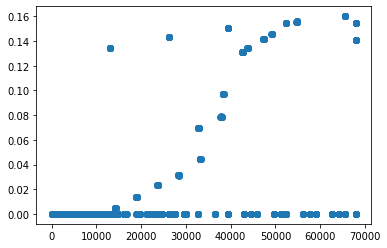

In [198]:
plt.scatter(samples.I_4,1/samples.W_100000)

In [199]:
samples_long['error']=abs(samples_long.est-height)

In [200]:
samples_long

,est_lb,est,est_ub,metric,size,error
0,60.748423,1560.748423,3060.748423,I_1,0.000000,1526.748423
1,35.164163,45.275892,55.387621,I_1,0.000000,11.275892
2,35.923875,35.953514,35.983153,I_1,0.000000,1.953514
3,37.689072,68.850854,100.012635,I_1,0.000000,34.850854
4,35.113257,35.291636,35.470014,I_1,0.000000,1.291636
...,...,...,...,...,...,...
70995,33.854024,36.875644,39.897263,W_100000,7.044559,2.875644
70996,33.854131,36.847337,39.840544,W_100000,7.054733,2.847337
70997,33.831318,36.814530,39.797743,W_100000,7.046641,2.814530
70998,33.838081,36.826905,39.815729,W_100000,7.051597,2.826905


In [201]:
I=samples_long[samples_long.metric.str.startswith('I')].groupby(['metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)
a=[]
for _,g in I.groupby('metric'):
    # b=interpolate.UnivariateSpline(g['size'], g['error'],k=3,s=2000)
    b=interpolate.LSQUnivariateSpline(g['size'], g['error'],k=3,t=[100,1000])
    new_error=b(g['size'],nu=0)
    a.extend(new_error)
I['smooth']=a
df=[]
for _,g in samples_long[samples_long.metric.str.startswith('I')].groupby('metric'):
    o=np.unique(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.20),axis=0)[:,1]
    df.extend(o)
    # df=pd.DataFrame(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.25)).drop_duplicates()
    # df.columns=(["size",'error'])
I['lowess']=np.array(df)
I=I.melt(id_vars=['size','metric'],value_vars=['smooth','lowess'],var_name="smoother",value_name="error")

/Users/terry/GNSS/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.


(0.0, 20.0)

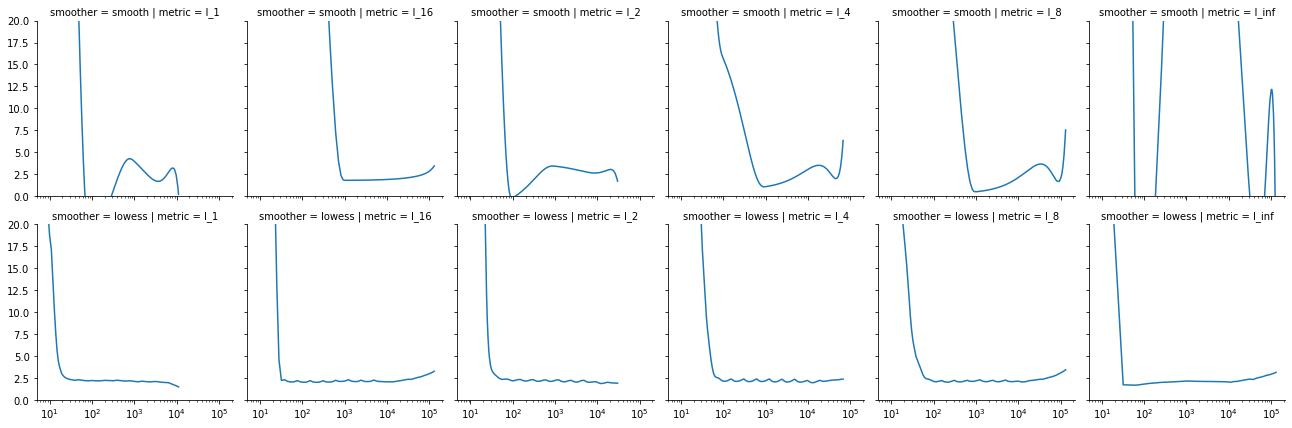

In [202]:
g=sns.FacetGrid(I,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='error')
plt.xscale('log')
plt.ylim(0,20)

In [210]:
I=samples_long[samples_long.metric.str.startswith('W')].dropna(axis=0).groupby(['metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)
a=[]
for _,g in I.groupby('metric'):
    b=interpolate.UnivariateSpline(g['size'], g['error'],k=3,s=2000)
    #b=interpolate.LSQUnivariateSpline(g['size'], g['error'],k=3,t=[100,1000])
    new_error=b(g['size'],nu=0)
    a.extend(new_error)
I['smooth']=a
I.shape

(8781, 4)

In [213]:
I.describe()

,size,error,smooth
count,8781.000000,8781.000000,0.0
mean,inf,4.820263,NaN
std,NaN,56.271157,NaN
min,0.008397,0.000062,NaN
25%,0.375113,1.718615,NaN
50%,1.484872,2.658297,NaN
75%,3.778701,2.949334,NaN
max,inf,1466.158895,NaN


In [212]:

df=[]
for _,g in samples_long[samples_long.metric.str.startswith('W')].groupby('metric'):
    o=np.unique(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.20),axis=0)[:,1]
    df.extend(o)
    # df=pd.DataFrame(sm.nonparametric.lowess(g['error'].values,g['size'].values,frac=0.25)).drop_duplicates()
    # df.columns=(["size",'error'])
np.array(df).shape


(8777,)

In [ ]:
I['lowess']=np.array(df)
I=I.melt(id_vars=['size','metric'],value_vars=['smooth','lowess'],var_name="smoother",value_name="error")

In [ ]:
g=sns.FacetGrid(I,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='error')
plt.xscale('log')
plt.ylim(0,20)

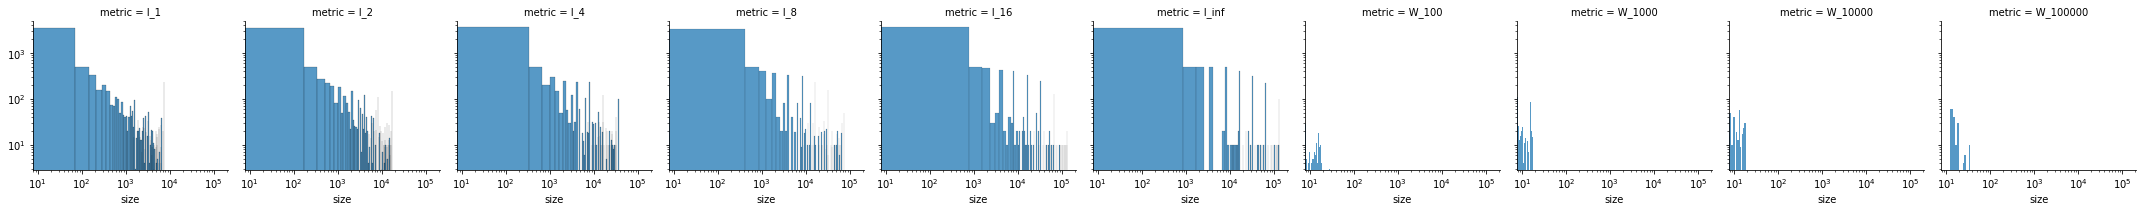

In [ ]:
g=sns.FacetGrid(samples.replace(np.inf,np.nan).dropna(axis=0),col='metric')
g.map(sns.histplot,'size')
plt.xscale('log')
plt.yscale('log')

Errors are completely wrong. need to redo

In [ ]:
ucl=pd.read_csv('../data/ucl_exact.csv')


In [ ]:
x=ucl[~ucl.height.isna()]
x.loc[:,'SS']=x.loc[:,'SS'].replace(np.nan,10)

In [ ]:
gm.algo.fit_edge(x.height.values,x.SS.values)

(14.70832000468112, 14.762473859945986, 14.816627715210853)

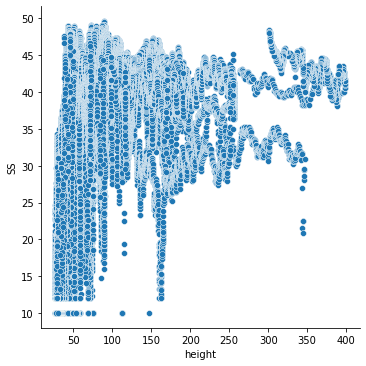

In [ ]:
sns.relplot(x='height',y='SS',data=x)

array([ 0.8,  0.1, 20. ,  0.2])

In [ ]:

model.fit_offline(x.height.values,x.SS.values,lik=False)[-1]

array([39.84001794,  0.37120691, 40.56569749, 13.56185205])

In [ ]:
samples